# **YOLO V1 Implementation for COTS dataset**

Going back to roots of YOLO architectures and implementing the first version from the YOLO family ***first introduced back in 2015*** being tested today to detect COTS.

This a just of fun implementations (obviously!) of YOLO V1, I've tried to mimic the original paper and architecture to as close as possible with a few tweaks here and there.
My main purpose here was to experiment on how the original YOLO v1 would perform on the present day object detection challenge.
The original YOLO v1 model was first trained on Image Classification dataset **ImageNet** and then fine-tuned on **COCO** dataset to perform Object detection. However no such pre-training on ImageNet has been done here due constraints, the model has been trained completely from scratch on COTS dataset.

**Any suggestions to further Improve mAP and minimize loss in terms of hyperparameters will be highly appreciated. I would very much like to test the limits of this architecture on this particular dataset. One such Idea would be to make use of modern day training procedures for object detection that promises improvements in accuracy.**

*The implementation is heavily inspired from this amazing [YouTube tutorial by Aladdin Persson](https://www.youtube.com/watch?v=n9_XyCGr-MI&list=PLhhyoLH6IjfxeoooqP9rhU3HJIAVAJ3Vz&index=47)*
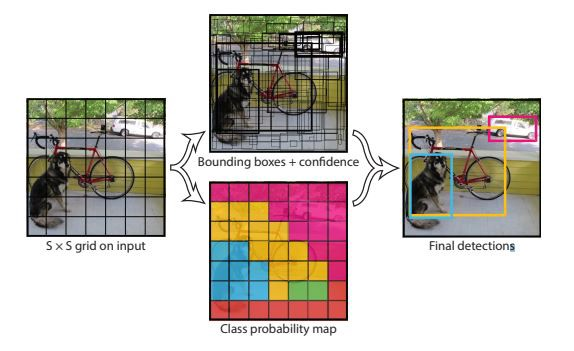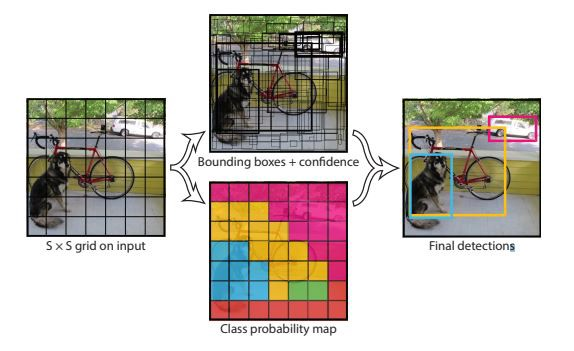

# **Import packages**

In [ ]:
!pip install torchsummary

In [ ]:
import os
from collections import Counter
from tqdm import tqdm
import sys
import ast

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import greatbarrierreef

# **Prepare Training dataset**

In [ ]:
INPUT_DIR = '/kaggle/input/tensorflow-great-barrier-reef/'
INPUT_DIR_IMG = '/kaggle/input/tensorflow-great-barrier-reef/train_images/'
sys.path.append(INPUT_DIR)
sys.path.append(INPUT_DIR_IMG)

In [ ]:
TRAINING_RATIO = 0.8

data_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))

# Split the dataset so that no sequence is leaked from the training dataset into the validation dataset.
split_index = int(TRAINING_RATIO * len(data_df))
while data_df.iloc[split_index - 1].sequence == data_df.iloc[split_index].sequence:
    split_index += 1

# Shuffle both the training and validation datasets.
train_data_df = data_df.iloc[:split_index].sample(frac=1).reset_index(drop=True)
val_data_df = data_df.iloc[split_index:].sample(frac=1).reset_index(drop=True)

train_positive_count = len(train_data_df[train_data_df.annotations != '[]'])
val_positive_count = len(val_data_df[val_data_df.annotations != '[]'])

print('Training ratio (all samples):', 
      float(len(train_data_df)) / (len(train_data_df) + len(val_data_df)))
print('Training ratio (positive samples):', 
      float(train_positive_count) / (train_positive_count + val_positive_count))

In [ ]:
# Take only the positive images for training and validation
train_data_df = train_data_df[train_data_df.annotations != '[]'].reset_index()
print('Number of positive images used for training:', len(train_data_df))
val_data_df = val_data_df[val_data_df.annotations != '[]'].reset_index()
print('Number of positive images used for validation:', len(val_data_df))

train_data_df["annotations"] = train_data_df["annotations"].map(lambda x : ast.literal_eval(x))
val_data_df["annotations"] = val_data_df["annotations"].map(lambda x : ast.literal_eval(x))

train_data_df["filepath"] = train_data_df.apply(lambda x : f"video_{x.video_id}/{x.video_frame}.jpg", axis=1)
val_data_df["filepath"] = val_data_df.apply(lambda x : f"video_{x.video_id}/{x.video_frame}.jpg", axis=1)

train_data_df.head(3)

In [ ]:
train_data_df.head(10)

In [ ]:
val_data_df.head(10)

In [ ]:
HEIGHT, WIDTH = 720, 1280
presize = 512
size = 384

df = train_data_df
# df = df.explode("annotations")

df["W"] = [WIDTH]*len(df)
df["H"] = [HEIGHT]*len(df)
df["label"] = [1]*len(df)

# df["x"] = df.apply(lambda x : x.annotations["x"]/1280, axis=1)
# df["y"] = df.apply(lambda x : x.annotations["y"]/720, axis=1)
# df["width"] = df.apply(lambda x : x.annotations["width"]/1280, axis=1)
# df["height"] = df.apply(lambda x : x.annotations["height"]/720, axis=1)

# df.loc[df["width"] > 1, "width"] = 1
# df.loc[df["height"] > 1, "height"] = 1

df = df.drop(["video_id","sequence","video_frame","sequence_frame",
              "image_id"], axis=1)

df = df.reset_index(drop=True)
df.head(3)

In [ ]:
vdf = val_data_df
# df = df.explode("annotations")

vdf["W"] = [WIDTH]*len(vdf)
vdf["H"] = [HEIGHT]*len(vdf)
vdf["label"] = [1]*len(vdf)

# df["x"] = df.apply(lambda x : x.annotations["x"]/1280, axis=1)
# df["y"] = df.apply(lambda x : x.annotations["y"]/720, axis=1)
# df["width"] = df.apply(lambda x : x.annotations["width"]/1280, axis=1)
# df["height"] = df.apply(lambda x : x.annotations["height"]/720, axis=1)

# df.loc[df["width"] > 1, "width"] = 1
# df.loc[df["height"] > 1, "height"] = 1

vdf = vdf.drop(["video_id","sequence","video_frame","sequence_frame",
              "image_id"], axis=1)

vdf = vdf.reset_index(drop=True)
vdf.head(3)

# **Defining YOLO Architecture**
Small add-on to the original architecture is **batch normalization**.
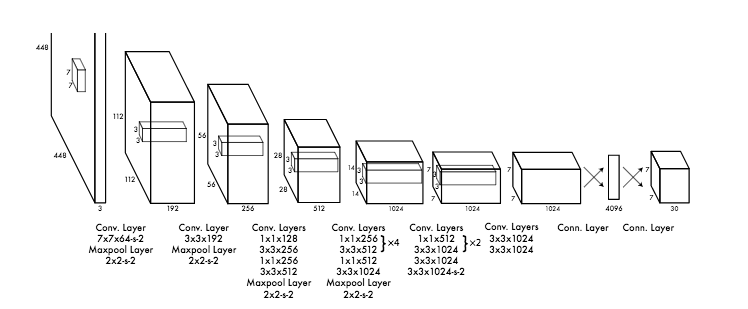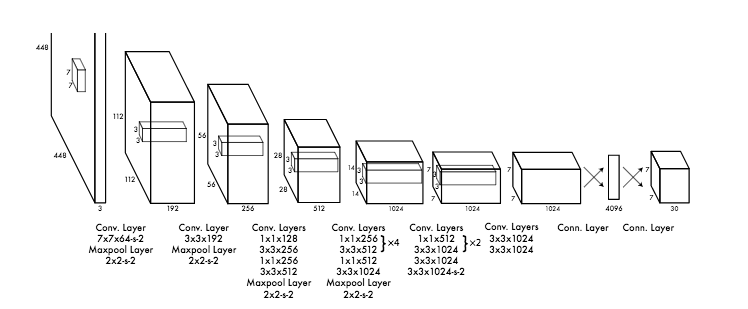

In [ ]:
architecture_config = [
                       #format: (kernel_size, num_filters, stride, padding)
                       (7, 64, 2, 3),
                       "M",
                       (3, 192, 1, 1),
                       "M",
                       (3, 128, 1, 0),
                       (1, 256, 1, 1),
                       (3, 256, 1, 0),
                       (1, 512, 1, 1),
                       "M",
                       [(1, 256, 1, 0),(3, 512, 1, 1), 4], # 4 = no. of times these two tuples should be repeated
                       (1, 512, 1, 0),
                       (3, 1024, 1, 1),
                       "M",
                       [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
                       (3, 1024, 1, 1),
                       (3, 1024, 2, 1),
                       (3, 1024, 1, 1),
                       (3, 1024, 1, 1),
]

In [ ]:
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(CNNBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, bias = False, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)
    self.leakyrelu = nn.LeakyReLU(0.1)

  def forward(self, x):
    return self.leakyrelu(self.batchnorm(self.conv(x)))

In [ ]:
class yolov1(nn.Module):
  def __init__(self, in_channels=3, **kwargs):
    super(yolov1, self).__init__()
    self.architecture = architecture_config
    self.in_channels = in_channels
    self.darknet = self._create_conv_layers(self.architecture)
    self.fcs = self._create_fcs(**kwargs)

  def forward(self, x):
    x = self.darknet(x)
#     print(x.shape)
    aap = nn.AdaptiveAvgPool2d((7,7))
#     print(x.shape)
    x = aap(x)
#     print(x.shape)
    return self.fcs(torch.flatten(x, start_dim=1))

  def _create_conv_layers(self, architecture):
    layers = []
    in_channels = self.in_channels

    for x in architecture:
      if type(x) == tuple:
        layers += [
                   CNNBlock(in_channels, 
                            x[1], 
                            kernel_size = x[0], 
                            stride = x[2], 
                            padding = x[3])
                  ]
        in_channels = x[1]

      elif type(x) == str:
        layers += [nn.MaxPool2d(kernel_size=2, stride = 2)]
      elif type(x) == list:
        conv_1 = x[0]
        conv_2 = x[1]
        num_repeats = x[2]

        for i in range(num_repeats):
          layers += [
                     CNNBlock(in_channels,
                              conv_1[1],
                              kernel_size = conv_1[0],
                              stride = conv_1[2],
                              padding = conv_1[3]),
                     CNNBlock(conv_1[1],
                              conv_2[1],
                              kernel_size = conv_2[0],
                              stride = conv_2[2],
                              padding = conv_2[3])
          ]

          in_channels = conv_2[1]
    return nn.Sequential(*layers)

  def _create_fcs(self, split_size, num_boxes, num_classes):
    S, B, C = split_size, num_boxes, num_classes
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(1024 * S * S, 512),
        nn.Dropout(0.0),
        nn.LeakyReLU(0.1),
        nn.Linear(512, S * S *(C + B * 5)),
    )

In [ ]:
def test(S = 7, B = 2, C = 1):
  model = yolov1(split_size = S, num_boxes = B, num_classes = C)
  x = torch.randn((1, 3, 672, 672))
  print(model(x).shape)

test()

# **YOLO Loss**

In [ ]:
class yololoss(nn.Module):
  def __init__(self, S = 7, B = 2, C = 1):
    super(yololoss, self).__init__()
    self.mse = nn.MSELoss(reduction="sum")
    self.S = S
    self.B = B
    self.C = C
    self.lambda_coord = 5
    self.lambda_noobj = 0.5

  def forward(self, prediction, target):
    prediction = prediction.reshape(-1, self.S, self.S, self.C + self.B * 5)
#     print(prediction.shape)

    iou_b1 = intersection_over_union(prediction[...,2:6], target[...,2:6])
    iou_b2 = intersection_over_union(prediction[...,7:11], target[...,2:6])

    ious = torch.cat([iou_b1.unsqueeze(0),iou_b2.unsqueeze(0)], dim =0)
    iou_maxes, best_box = torch.max(ious, dim=0)
    exists_box = target[..., 1].unsqueeze(3) #Iobj_i
    
    if torch.sum(best_box) > 1:
        best_box = 1
    else:
        best_box = 0
    ####  BOX LOSS  ####
    #Box-Coordinates (mid-point, width & height)
    box_predictions = exists_box * (
        (
            best_box * prediction[...,7:11]
            + (1 - best_box) * prediction[...,2:6]
        )
    )

    box_targets = exists_box * target[...,2:6]

    box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
        torch.abs(box_predictions[..., 2:4] + 1e-6)
    )
    
    #box dimensions: (N, S, S, 6)
    box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
    #(N, S, S, 4) -> (N*S*S, 4)
    box_loss = self.mse(torch.flatten(box_predictions, end_dim=-2),
                        torch.flatten(box_targets, end_dim=-2),
                        )
    
    #### OBJECT LOSS ####
    pred_box = (
        best_box * prediction[..., 6:7] + (1 - best_box) * prediction[...,1:2]
    )
    # (N,S,S,1) -> (N*S*S*1)
    object_loss = self.mse(
        torch.flatten(exists_box * pred_box),
        torch.flatten(exists_box * target[...,1:2])
    )

    #### NO-OBJECT LOSS ####
    #(N, S, S, 1) -> (N, S*S*1)
    no_object_loss = self.mse(
        torch.flatten((1 - exists_box) * prediction[..., 1:2], start_dim=1),
        torch.flatten((1 - exists_box) * target[..., 1:2], start_dim=1),
    )

    no_object_loss = self.mse(
        torch.flatten((1 - exists_box) * prediction[..., 6:7], start_dim=1),
        torch.flatten((1 - exists_box) * target[..., 1:2], start_dim=1),
    )

    class_loss = self.mse(
        torch.flatten(exists_box * prediction[...,:1], end_dim = -2),
        torch.flatten(exists_box * target[...,:1], end_dim = -2)
    )

    loss = (
        self.lambda_coord * box_loss 
        + object_loss
        + self.lambda_noobj * no_object_loss
        + class_loss
    )

    return loss

# **Creating PyTorch Dataset Class for COTS**

In [ ]:
class COTSDataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, img_dir,
               S=7, B=2, C=1, transform=None):
    self.annotations = dataframe
    self.img_dir = img_dir
    self.transform = transform
    self.S = S
    self.C = C
    self.B = B

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
#     label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
    boxes = []
#     with open(label_path) as f:
    for box in self.annotations["annotations"][index]:
        class_label, x, y, width, height = self.annotations["label"][index], box["x"]/1280, box["y"]/720, box["width"]/1280, box["height"]/720
        boxes.append([class_label, x, y, width, height])

    img_path = os.path.join(self.img_dir, self.annotations["filepath"][index])
    image = Image.open(img_path)
    boxes = torch.Tensor(boxes)

    if self.transform:
      image, boxes = self.transform(image, boxes)

    label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))

    for box in boxes:
      class_label, x, y, width, height = box.tolist()
      class_label = int(class_label)
      i, j = int(self.S * x), int(self.S * y)
      x_cell, y_cell = self.S * x - i, self.S * y - j
      width_cell, height_cell = (
          width * self.S,
          height *self.S,
      )

      if label_matrix[i, j, 1] == 0:
        label_matrix[i, j, 1] = 1 
        box_coordinates = torch.Tensor(
            [x_cell, y_cell, width_cell, height_cell]
        )
        label_matrix[i,j, 2:6] = box_coordinates
        label_matrix[i,j, class_label] = 1

      return image, label_matrix



# **Utility Funtions**

Wrote a few utility fucntions commonly used for object detection from scratch to understand them even better. Definitely, by far it's not the best and the most efficient implementation of these algorithms.

In [ ]:

def intersection_over_union(boxes_pred, boxes_labels, box_format = "midpoint"):

  if box_format == "midpoint":
    box1_x1 = boxes_pred[..., 0:1] - boxes_pred[..., 2:3]/2
    box1_y1 = boxes_pred[..., 1:2] - boxes_pred[..., 3:4]/2
    box1_x2 = boxes_pred[..., 0:1] + boxes_pred[..., 2:3]/2
    box1_y2 = boxes_pred[..., 1:2] + boxes_pred[..., 3:4]/2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3]/2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4]/2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3]/2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4]/2

  elif box_format == "corners":
    box1_x1 = boxes_pred[..., 0:1]
    box1_y1 = boxes_pred[..., 1:2]
    box1_x2 = boxes_pred[..., 2:3]
    box1_y2 = boxes_pred[..., 3:4]
    box2_x1 = boxes_labels[..., 0:1]
    box2_y1 = boxes_labels[..., 1:2]
    box2_x2 = boxes_labels[..., 2:3]
    box2_y2 = boxes_labels[..., 3:4]

  x1 = torch.max(box1_x1, box2_x1)
  y1 = torch.max(box1_y1, box2_y1)
  x2 = torch.min(box1_x2, box2_x2)
  y2 = torch.min(box1_y2, box2_y2)

  intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
#   print(intersection)

  box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
  box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

  union  = box1_area + box2_area -intersection

  return intersection/(union + 1e-6)



def non_max_suppression(
    bboxes,
    iou_threshold,
    prob_threshold,
    box_format = "corners"
                      ):
  
  assert type(bboxes) == list

  bboxes = [box for box in bboxes if box[1] > prob_threshold]
  bboxes = sorted(bboxes, key=lambda x : x[1], reverse = True)
  bboxes_aft_nms = []

  while bboxes:
    chosen_box = bboxes.pop(0)

    bboxes = [
              box for box in bboxes
              if box[0] != chosen_box[0]
              or intersection_over_union(
                  torch.Tensor(chosen_box[2:]),
                  torch.Tensor(box[2:]),
                  box_format = box_format
              ) < iou_threshold
    ]

    bboxes_aft_nms.append(chosen_box)

  return bboxes_aft_nms



def mean_average_precision(pred_boxes, true_boxes, iou_threshold = 0.5, box_format="corners", num_classes=20):

  #pred_boxes_format = [[train_id, class_prob, box_prob, x1, y1, x2, y2], ...]
  average_precisions = []
  epsilon = 1e-6

  for c in range(num_classes):
    detections = []
    ground_truths = []

    for detection in pred_boxes:
      if detection[1] == c:
        detections.append(detection)

    for true_box in true_boxes:
      if true_box[1] == c:
        ground_truths.append(true_box)

    amount_boxes = Counter([gt[0] for gt in ground_truths])
    
    for key, val in amount_boxes.items():
      amount_boxes[key] = torch.zeros(val)

    detections.sort(key = lambda x: x[2], reverse = True)
    TP = torch.zeros((len(detections)))
    FP = torch.zeros((len(detections)))
    total_true_bboxes = len(ground_truths)

    for detection_idx, detection in enumerate(detections):
      ground_truth_img = [
              bbox for bbox in ground_truths  if bbox[0] == detection[0]
                   ]

      num_gts = len(ground_truth_img)
      best_iou = 0

      for idx, gt in enumerate(ground_truth_img):
        iou = intersection_over_union(
            torch.Tensor(detection[3:]),
            torch.Tensor(gt[3:]),
            box_format = box_format,
            )
        
        if iou > best_iou:
          best_iou = iou
          best_gt_idx = idx

      if best_iou > iou_threshold:

        if amount_boxes[detection[0]][best_gt_idx] == 0:
            TP[detection_idx] = 1
            amount_boxes[detection[0]][best_gt_idx] = 1
        else:
            FP[detection_idx] = 1
       
      else:
        FP[detection_idx] = 1 

    TP_cumsum = torch.cumsum(TP, dim=0)
    FP_cumsum = torch.cumsum(FP, dim=0)
    recalls = TP_cumsum / (total_true_bboxes + epsilon)
    precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
    precisions = torch.cat((torch.tensor([1]), recalls))
    recalls = torch.cat((torch.tensor([0]), recalls))
    average_precisions.append(torch.trapz(precisions, recalls))

  return sum(average_precisions) / len(average_precisions)



def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. 
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 11)
    bboxes1 = predictions[..., 2:6]
    bboxes2 = predictions[..., 7:11]
    scores = torch.cat(
        (predictions[..., 1].unsqueeze(0), predictions[..., 6].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :1].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 1], predictions[..., 6]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds



def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes



def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                prob_threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [ ]:
m = nn.AdaptiveAvgPool2d((5,7))
inp = torch.randn(1, 64, 8, 9)
output = m(inp)
output.shape

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
load_path = "../input/custom-yolov1-from-scratch/yolov1.pth"
model = yolov1(split_size = 7, num_boxes=2, num_classes = 1).to(DEVICE)
state_dict = torch.load(load_path)
model.load_state_dict(state_dict)
model.fcs = nn.Sequential(
#     nn.AdaptiveAvgPool2d((9,7)),
    nn.Flatten(),
    nn.Linear(1024 * 7 * 7, 512),
    nn.Dropout(0.0),
    nn.LeakyReLU(0.1),
    nn.Linear(512, 7 * 7 *(1 + 2 * 5)),
)
model.to(DEVICE)

summary(model, (3, 672, 672))

# **Training Loop**

In [ ]:
seed = 123
torch.manual_seed(seed)
IMG_DIR = "../input/tensorflow-great-barrier-reef/train_images"
lr = 3e-5
BATCH_SIZE = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 5
save_path = "yolov1_2.pth"
fine_tune = True
load_path = "../input/custom-yolov1-from-scratch/yolov1.pth"


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

transform = Compose([transforms.Resize((672, 672)), transforms.ToTensor(),])




def train_fn(train_loader, test_loader, model, optimizer, loss_fn):
  loop = tqdm(train_loader, leave= True)
  mean_loss = []
  mean_test_loss = []

  for batch_id, (x,y) in enumerate(loop):
    x,y = x.to(DEVICE), y.to(DEVICE)
    out = model(x)
#     print(out.shape)
#     print(y.shape)
    loss = loss_fn(out,y)
    mean_loss.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loop.set_postfix(loss = loss.item())
    
  model.eval()
  for batch_idx, (x, labels) in enumerate(test_loader):
        x = x.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            predictions = model(x)
        
        test_loss = loss_fn(predictions, labels)
        mean_test_loss.append(test_loss.item())
        
  model.train() 
    
#   scheduler.step()

    
  print(f"Mean loss was{sum(mean_loss)/len(mean_loss)}")
  print(f"Test Mean loss was{sum(mean_test_loss)/len(mean_test_loss)}")
 

def main():
  model = yolov1(split_size = 7, num_boxes=2, num_classes = 1).to(DEVICE)
  optimizer = optim.SGD(model.parameters(), lr = lr)
#   scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 50)
  loss_fn = yololoss()

  if fine_tune:
    state_dict = torch.load(load_path, map_location=DEVICE)
    model.load_state_dict(state_dict)

  train_dataset = COTSDataset(df, img_dir = IMG_DIR, transform = transform)

  test_dataset = COTSDataset(vdf, img_dir = IMG_DIR, transform = transform)

  train_loader = DataLoader(
      dataset = train_dataset,
      batch_size = BATCH_SIZE,
      shuffle=True,
      drop_last = True
  )

  test_loader = DataLoader(
      dataset = test_dataset,
      batch_size = 2,
      shuffle=True,
      drop_last = True
  )


  for epochs in range(EPOCHS):


    pred_boxes, target_boxes = get_bboxes(
            test_loader, model, iou_threshold=0.5, threshold=0.4
        )

    mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
    print(f"Valid mAP: {mean_avg_prec}")

    train_fn(train_loader, test_loader, model, optimizer, loss_fn)
    
#     scheduler.step()
#     print(scheduler.get_lr())
    
    torch.save(model.state_dict(), save_path)

    #  if mean_avg_prec > 0.9:
    #        checkpoint = {
    #            "state_dict": model.state_dict(),
    #            "optimizer": optimizer.state_dict(),
    #        }
    #        save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)

In [ ]:
main() #uncomment to start training loop

In [ ]:
model = yolov1(split_size = 7, num_boxes=2, num_classes = 1).to(DEVICE)
state_dict = torch.load("./yolov1_2.pth")
model.load_state_dict(state_dict)

train_dataset = COTSDataset(df, img_dir = IMG_DIR, transform = transform)

test_dataset = COTSDataset(vdf, img_dir = IMG_DIR, transform = transform)

train_loader = DataLoader(
  dataset = train_dataset,
  batch_size = BATCH_SIZE,
  shuffle=True,
  drop_last = True
)

pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
    )
print(f"train mAP: {mean_avg_prec}")

In [ ]:
for epoch in range(4):
    for x, y in train_loader:
       x = x.to(DEVICE)
       for idx in range(8):
           bboxes = cellboxes_to_boxes(model(x))
           bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, prob_threshold=0.4, box_format="midpoint")
           plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

       import sys
       sys.exit()